# Analysis of Gender Bias in Tech Job Postings

### CSE 184: Fall 2019 - Nikhil Dodd, Jerico Factor, Kyle O’Brien, Bryan Jimenez

## Motivation

It's common knowledge that a majority of software engineers identify as male. Despite gains in gender diversity across other STEM professions, software engineering remains largely stagnant. There is a myriad of factors influencing this reality.

We're interested in exploring the role the wording of job postings play in potentially discouraging non-male candidates from applying. This project is inspired by Textio. ----------------FIX

## Questions

1. Out of X randomly collected software engineering jobs, what percentage have gender-specific pronouns?
2. What’s the percentage breakdown by state/region?
3. What are the most common keywords that encourage/discourage applicants?
4. Does the company size or location influence a company's inclusion initiatives? ----------------FIX

## Data Source

As our data source, we'll be using hte LinkedIn job search tool. ----------------FIX

### Import Dependencies 

In [1]:
import numpy as np
import pandas as pd
import nltk
from matplotlib import pyplot as plt
import csv
import requests
import collections
from bs4 import BeautifulSoup
import geopandas as gpd
import pandas_bokeh
from shapely.geometry import Point, Polygon
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from math import pi
from bokeh.plotting import figure, output_file, show
import plotly
import plotly.figure_factory as ff
import plotly.graph_objects as go
import numpy as np
import pandas as pd
import csv
import requests
import collections
from bs4 import BeautifulSoup
import re
import json

%matplotlib notebook
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/jrko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## Corpus

----- Reasoning and sources

In [2]:
gender_pronouns = [
    "he",
    "him",
    "she",
    "her",
    "his",
    "hers"
]

masculine_themed_wording = [
    "competitive",
    "dominate",
    "leader",
    "rock star",
    "rockstar",
    "guru",
    "ninja",
    "hacker",
    "superhero",
    "prove themselves",
    "analyze",
    "determine",
    "crush it",
    "world class",
    "superior",
    "ambitious",
    "aggressive",
    "leader", 
]

obviously_masculine_subset =[
    'competitive', 
    'dominate', 
    'rockstar',
    'rock star', 
    'ninja', 
    'superhero',
    'world class',
    'superior', 
    'ambitious', 
    'aggressive', 
    'ambitious', 
    'crush it', ]

states = [
    'AL',
    'AK',
    'AZ',
    'AR',
    'CA',
    'CO',
    'CT',
    'DE',
    'DC',
    'FL',
    'GA',
    'HI',
    'ID',
    'IL',
    'IN',
    'IA',
    'KS',
    'KY',
    'LA',
    'ME',
    'MD',
    'MA',
    'MI',
    'MN',
    'MS',
    'MO',
    'MT',
    'NE',
    'NV',
    'NH',
    'NJ',
    'NM',
    'NY',
    'NC',
    'ND',
    'OH',
    'OK',
    'OR',
    'PA',
    'RI',
    'SC',
    'SD',
    'TN',
    'TX',
    'UT',
    'VT',
    'VA',
    'WA',
    'WV',
    'WI',
    'WY' 
]

job_positions = [
    "developer",
    "engineer",
    "software engineer",
    "software developer",
    "product manager",
    "manager",
    "product developer",
    "tech lead",
    "lead",
    "analyst",
    "head",
    "designer"
]

common_job_roles = [
    "engineer", 
    "designer", 
    "manager",
    "analyst",
    "scientist",
    "director"
    "chief officer",
    "sales",
    "marketing",
]



## Load Dataset
Note: Breifly explain data collection process

In [2]:
all_jobs = pd.read_csv("../data/derived_job_data.csv")
all_jobs.head(15)

,job_title,company,location,description
0,MicroStrategy Developers HERE IN McLean VA (Fa...,Advansys Inc,VA,HelloPlease find the below requirement and do ...
1,Security Architect - Palo Alto Firewalls,Alagen,AZ,Alagen has combined over 20 years of recruitin...
2,Dynamics AX Senior System/Security Admin/Globa...,ConsultantFriends.com,IL,MS Dynamics System and Security Admin Global I...
3,IAM Consultant,Collabera,IL,Job ID5457_IAM_ILJob TitleIAM ConsultantJob Lo...
4,.Net Developer,Network Objects Inc.,CT,Net DeveloperHartford CTFULL TIMERequirements5...
5,DevOps Windows/ Linux Engineer,Associated Press,NJ,Position Application EngineerJob SummaryProvid...
6,Solution Architect,Caprus IT Inc.,MI,Hi We do have an urgent requirement Job Title...
7,Immediate openings for Physical Design Enginee...,Calsoft Labs,CA,Job Overview Floor planning PR timing closure...
8,Service Delivery Manager,Matlen Silver,NJ,MUST HAVE ENCRYPTION EXPERIENCE Looking for a ...
9,Management Consultant,Windsor Partners,CA,Duties and ResponsibilitiesConsultants play a ...


### Collect Gendered Jobs

In [4]:
gendered_jobs = pd.DataFrame()

for gendered_word in (gender_pronouns + masculine_themed_wording):
    results = all_jobs.where(all_jobs["description"].str.find(gendered_word) != -1)
    gendered_jobs = pd.concat([gendered_jobs, results])
    
gendered_jobs = gendered_jobs.drop_duplicates(keep=False)
gendered_jobs.shape[0]

2474

### First we'll get the information from the data frame

In [6]:
def stem_tokens(s): 
#This function creates a list of stemmed words from a string
    ps = PorterStemmer()
    tokens = word_tokenize(s)
    stem = list(map(lambda x : ps.stem(x), tokens))
    
    return stem 

In [7]:
tokenized_description = all_jobs['description'].apply(lambda x: ' '.join(stem_tokens(x)))
# tokenized_description = pd.read_csv('dataWithStemmedDescription.csv')['description']

KeyboardInterrupt: 

In [8]:
def phraseCount(phrase, description): 
#this counts the amount of times phrase shows up in description
    s = '\\b(' + phrase + ')\\b'
    regex = re.compile(s,re.IGNORECASE)
    return len(re.findall(regex, description))

In [9]:
def indicesOfJobsWithPhrase(phrase, df, descriptionDict): 
# this given a phrase, data frame, stemmed description list
# it will find if the phrase is in the description or the stemmed description
# if it is it will return the indices of these jobs that contain this phrase
    indices = []
    for index, row in df.iterrows(): 
        stemmedPhrase = ' '.join(stem_tokens(phrase))
        if phraseCount(phrase,row.get('description')) > 0 \
        or phraseCount(stemmedPhrase, descriptionDict[index]) > 0: 
            indices.append(index)
    return indices


In [5]:
def computeStateInfo(state, full_df,descriptions,themed_wording): 
# this finds the information of the individual words for this state
# there will be a word count, indicies of the data set where it is found
# number percentage of biased jobs for this state
    stateInfo = {}
    stateInfo['region'] = state
    stateInfo['word_count'] = {}
    stateInfo['word_indices'] = {}
    state_df = full_df.where(full_df['location'] == state).dropna()
    biasedIndices = []; 
    
    for word in themed_wording: 
        
        indices = indicesOfJobsWithPhrase(word, state_df, descriptions)
        stateInfo['word_count'][word] = len(indices)
        stateInfo['word_indices'][word] = indices
        biasedIndices += indices
    
    topWords = [item[0] for item in reversed(sorted(stateInfo['word_count'].items(), key = lambda kv: kv[1]))][:5]
    
    stateInfo['numberOfJobsInDataSet'] = len(state_df)
    stateInfo['numberOfBiasedJobs'] = len(set(biasedIndices))
    try: 
        stateInfo['percentageOfBiasedJobs'] = float(stateInfo['numberOfBiasedJobs']/ stateInfo['numberOfJobsInDataSet']) * 100
    except ZeroDivisionError: 
        stateInfo['percentageOfBiasedJobs'] = 'NA'
                                                                                                               
    stateInfo['questionFour'] = topWords
    stateInfo['questionFive'] = {kv[0]: (kv[1] / stateInfo['numberOfJobsInDataSet'] * 100 if stateInfo['numberOfJobsInDataSet'] > 0 else 'NA')
                                         for kv in stateInfo['word_count'].items()}
    return stateInfo

In [4]:
def exportInfo(DF,themed_wording,name): 
# this function creates a list of dictionaries of state information for all states
# this also writes it to a csv file with the given name
    data = [computeStateInfo(state, DF,tokenized_description,themed_wording) for state in states]
    stateData = data; 
    with open(name+'.json', 'w') as outfile:
        json.dump(stateData, outfile,indent = 4)
    return stateData

In [3]:
import time
startTime = time.time()

themed_wording = masculine_themed_wording
name = 'originalMasculineWords'

stateData = exportInfo(all_jobs,themed_wording,name)

runtime = time.time() - startTime
print("runtime:",runtime)

NameError: name 'masculine_themed_wording' is not defined

In [10]:
def getPercentagesOverall(stateData): 
    numberOfGenderedJobs = sum([state['numberOfBiasedJobs']for state in stateData])
    numberOfJobs = all_jobs.shape[0]
    percentageOfGenderedJobs = numberOfGenderedJobs / numberOfJobs * 100
    print('percentage of gendered jobs:', percentageOfGenderedJobs)
    print('number of gendered jobs:', numberOfGenderedJobs)

## Question 1: What percentage has gender pronouns in the job posting?

Here we will find which job postings contain the actual pronouns in the job listings. We check if they are more biased towards masculine gender pronouns. 

In [11]:
def phraseCount(phrase, description): 
    #this counts the amount of times phrase shows up in description
    s = '\\b(' + phrase + ')\\b'
    regex = re.compile(s,re.IGNORECASE)
    return len(re.findall(regex, description))

In [12]:
def findNumberOfJobsWithPronouns(data_set): 
    mpronouns = ['he', 'him' ,'his']
    fpronouns = ['she', 'her', 'hers']
    pronounCounter = 0
    mascPronounCounter = 0
    femPronounCounter = 0
    for index, row in data_set.iterrows():
        mcount = 0
        fcount = 0
        for word in mpronouns: 
            mcount += phraseCount(word, row.get('description'))
        for word in fpronouns: 
            fcount += phraseCount(word, row.get('description'))
        if mcount + fcount > 0:
            pronounCounter +=1 
        if mcount > fcount: 
            mascPronounCounter += 1
        if mcount < fcount: 
            femPronounCounter += 1

    print('Number of jobs that have gendered pronouns:', pronounCounter, " percentage: ", pronounCounter/data_set.shape[0] * 100)
    print('More masculine pronouns:', mascPronounCounter," percentage: ", mascPronounCounter/pronounCounter * 100)
    print('More feminine pronouns:', femPronounCounter," percentage: ", femPronounCounter/pronounCounter * 100)

In [13]:
findNumberOfJobsWithPronouns(all_jobs)

Number of jobs that have gendered pronouns: 337  percentage:  1.6792904125971695
More masculine pronouns: 123  percentage:  36.49851632047478
More feminine pronouns: 80  percentage:  23.738872403560833


We find that about 1.7% of the job listings in our data set have those gendered phrases. But of those listings, 36% contain more masculine pronouns while only 24% contain more feminine pronouns.

## Questions 2: How are gendered job postings distributed across the USA?

In [20]:
%matplotlib notebook

In [21]:
with open ('originalMasculineWords.json') as jsonfile: 
    jsonInfo = json.load(jsonfile)
getPercentagesOverall(jsonInfo)

percentage of gendered jobs: 34.93621686266693
number of gendered jobs: 7011


<IPython.core.display.Javascript object>


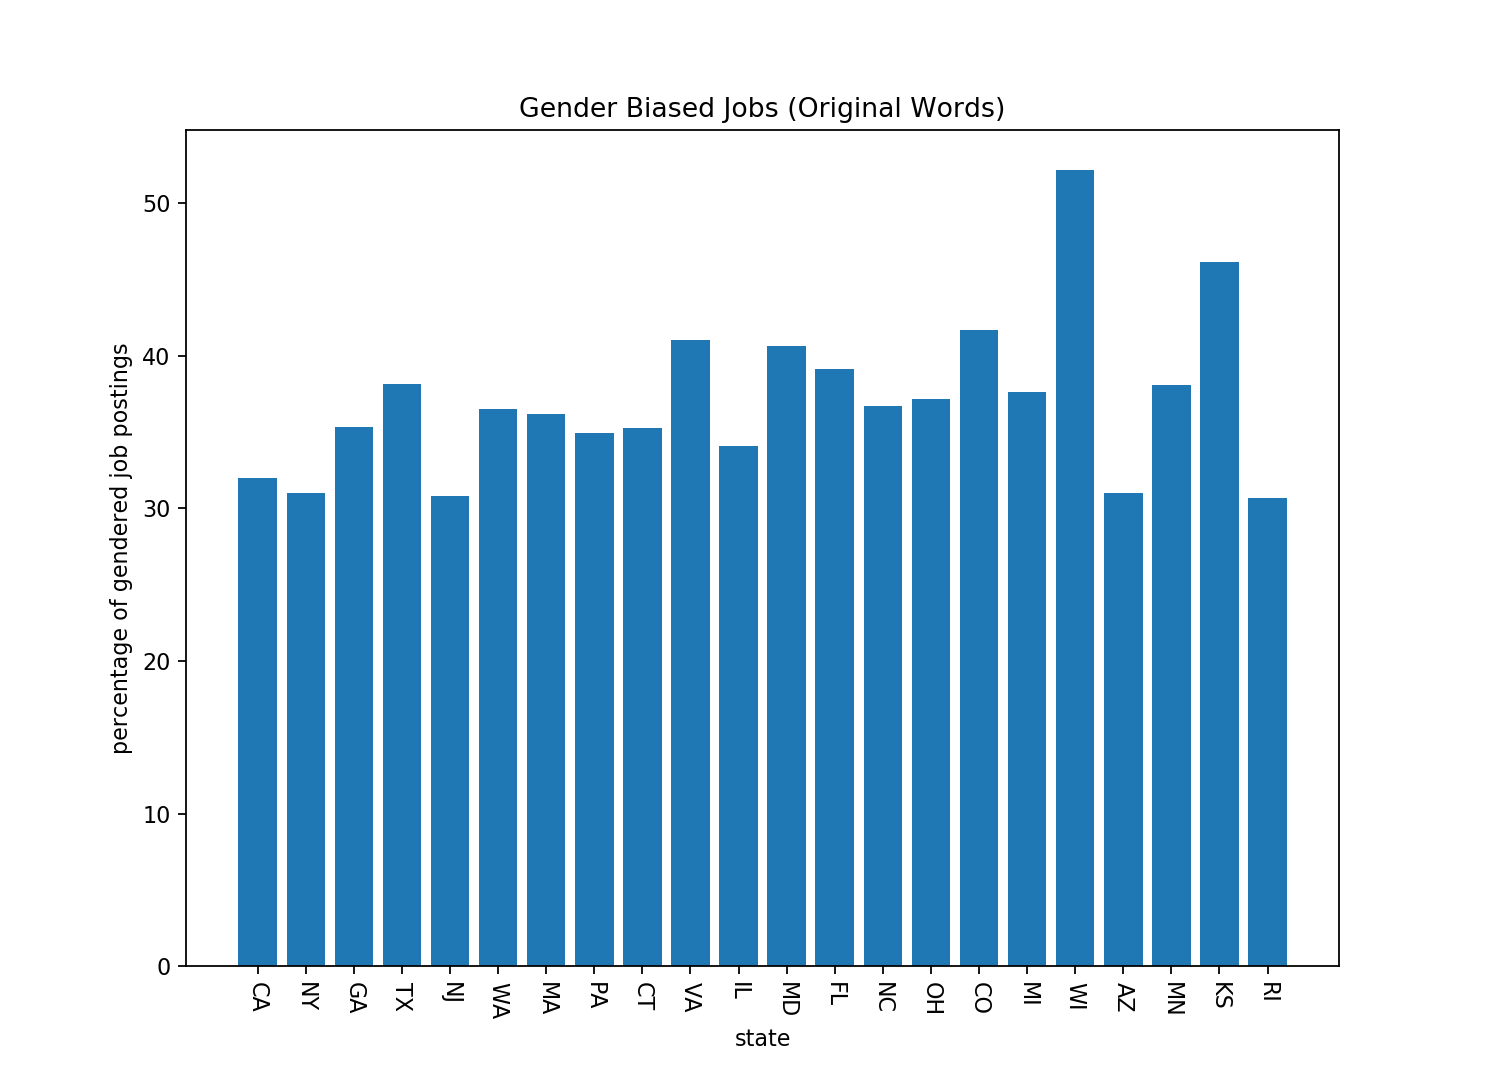

Text(0.5, 1.0, 'Gender Biased Jobs (Original Words)')

In [22]:
fig1 , ax = plt.subplots()
x = [state['region'] for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA'and state['numberOfJobsInDataSet'] >= 100]
y = [float(state['percentageOfBiasedJobs']) for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA'and state['numberOfJobsInDataSet'] >= 100]

ax.bar(x,y)
ax.tick_params(axis='x', which='major', rotation = 270)
ax.set_xlabel('state')
ax.set_ylabel('percentage of gendered job postings')
ax.set_title('Gender Biased Jobs (Original Words)')

This bar graph shows that on average there is about 30% of gendered job across the United States. Since some of our states have much more jobs than others, We ordered the states in the amount of data we had per state. The states towards the end of the graph have single digits. There is no significanct evidence that that some states are more gender biased than others as the percentages are very close to each other

In [23]:
with open ('obviouslyMasculineWording.json') as jsonfile: 
    jsonInfo = json.load(jsonfile)
getPercentagesOverall(jsonInfo)
jsonInfo

percentage of gendered jobs: 12.387881203906717
number of gendered jobs: 2486


[{'region': 'AL',
  'word_count': {'competitive': 5,
   'dominate': 0,
   'rockstar': 0,
   'rock star': 0,
   'ninja': 0,
   'superhero': 0,
   'world class': 0,
   'superior': 0,
   'ambitious': 0,
   'aggressive': 1,
   'crush it': 0},
  'word_indices': {'competitive': [3066, 10038, 15205, 16054, 18017],
   'dominate': [],
   'rockstar': [],
   'rock star': [],
   'ninja': [],
   'superhero': [],
   'world class': [],
   'superior': [],
   'ambitious': [],
   'aggressive': [6490],
   'crush it': []},
  'numberOfJobsInDataSet': 26,
  'numberOfBiasedJobs': 6,
  'percentageOfBiasedJobs': 23.076923076923077,
  'questionFour': ['competitive',
   'aggressive',
   'crush it',
   'ambitious',
   'superior'],
  'questionFive': {'competitive': 19.230769230769234,
   'dominate': 0.0,
   'rockstar': 0.0,
   'rock star': 0.0,
   'ninja': 0.0,
   'superhero': 0.0,
   'world class': 0.0,
   'superior': 0.0,
   'ambitious': 0.0,
   'aggressive': 3.8461538461538463,
   'crush it': 0.0}},
 {'region':

<IPython.core.display.Javascript object>


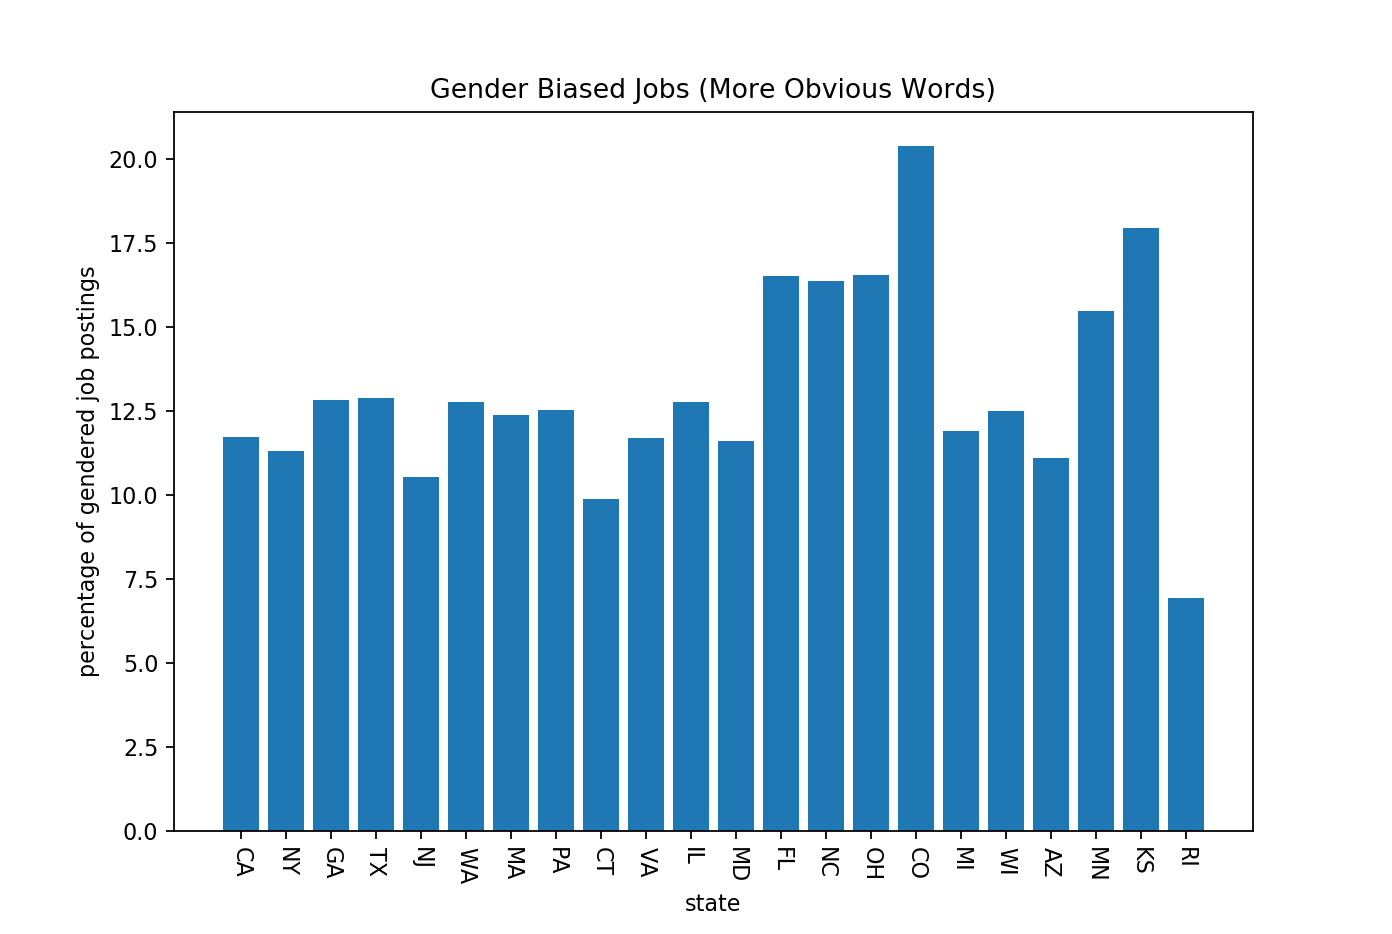

Text(0.5, 1.0, 'Gender Biased Jobs (More Obvious Words)')

In [24]:
fig2 , ax = plt.subplots()
x = [state['region'] for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA' and state['numberOfJobsInDataSet'] >= 100]
y = [float(state['percentageOfBiasedJobs']) for state in reversed(sorted(jsonInfo, key = lambda x: x['numberOfJobsInDataSet'])) if state['percentageOfBiasedJobs'] != 'NA' and state['numberOfJobsInDataSet'] >= 100]

ax.bar(x,y)
ax.tick_params(axis='x', which='major', rotation = 270)
ax.set_xlabel('state')
ax.set_ylabel('percentage of gendered job postings')
ax.set_title('Gender Biased Jobs (More Obvious Words)')

By using a subset which we dropped terms that sounded more neutral to us like 'analyze' and 'leader' and taking the percentage of those, we get an average of about 12%

## Question 3: What are the most common roles in tech that have gendered job postings?

Note: Explination and Process

In [ ]:
common_roles_occurences = [
    "developer",
    "frontend",
    "backend",
    "UX",
    "engineer",
    "product",
    "manager",
    "lead",
    "analyst",
    "scientist",
    "designer",
    "sales",
    "marketing",
    "accountant",
    "devops"
]

jobs_captured = 0

for role in common_roles_occurences:
    x = all_jobs["job_title"].where(all_jobs["description"].str.find(role) > -1)
    y = gendered_jobs["job_title"].where(gendered_jobs["description"].str.find(role) > -1)
    count = 0
    desc_arr2 = [] # not sure if this array is needed yet, search for the positions

    for item, frame in y.iteritems():
        if pd.notnull(frame):
            count+=1
            desc_arr2.append(item)
            
    jobs_captured += count
    print(f"Uses the word(s) {role}: ", count)
    print(f"percentage {(count / all_jobs.shape[0]) * 100}\n\n")
    
print(jobs_captured)
# NEEEEDS VIZ

## Question 4: Out of the gendered words/phrases, which are the most common? 

In [5]:
pandas_bokeh.output_notebook()

Loading BokehJS ...

In [12]:
'''
1. Take in the word from the updated list 
2. Check if word appears in the description
    - if it does, add it to the list
    - if NOT, do not add it to the list
3. After getting the jobs, get the exclusive jobs using list(set(list_name)) <-- these are indexes
4. With the job descriptions, loop through the list, add each of the columns that we want to its own list
5. Create the column and set it to that list
6. Get the states using the lambda function
'''

# Loops through the updated phrase list and appends to a list with the indexes of the jobs that have the phrases

masculine_themed_wording_updated = masculine_themed_wording
jobs = all_jobs

job_index_list = []
count_list = []

for word in masculine_themed_wording_updated:
    print("Current word: ", word)
    x = jobs['description'].where(jobs['description'].str.find(word) > -1)
    #vals = jobs['jobdescription'].str.count(word)
    #print(word, " appears ", vals, " times")
    #print(x)
    count = 0
    for item, frame in x.iteritems():
        if pd.notnull(frame):
            job_index_list.append(item)
            count+=1
    count_list.append(count)        
    
job_index_list_exec = list(set(job_index_list))
print("Length of original list: ", len(job_index_list))
print("Length of exclusive list: ", len(job_index_list_exec))
print("List of word counts: ", count_list)


print("without duplicates: ", job_index_list_exec)

# Create the dataframe called 'new_jobs' which contains the jobs that contain the phrases from the list
# In the cell BELOW is a function for this, there is just a block of code to run this

job_title_list = []
job_company_list = []
job_location_list = []
job_desc_list = []

for i in job_index_list_exec:
    job_title_list.append(jobs['job_title'].iloc[i])
    job_company_list.append(jobs['company'].iloc[i])
    job_location_list.append(jobs['location'].iloc[i])
    job_desc_list.append(jobs['description'].iloc[i])

new_jobs = pd.DataFrame(job_index_list_exec, index = job_index_list_exec, columns = ["Job Number"])
new_jobs["Job Title"] = job_title_list
new_jobs["Company"] = job_company_list
new_jobs["Location"] = job_location_list
new_jobs["Description"] = job_desc_list

Current word:  competitive
Current word:  dominate
Current word:  leader
Current word:  rock star
Current word:  rockstar
Current word:  guru
Current word:  ninja
Current word:  hacker
Current word:  superhero
Current word:  prove themselves
Current word:  analyze
Current word:  determine
Current word:  crush it
Current word:  world class
Current word:  superior
Current word:  ambitious
Current word:  aggressive
Current word:  leader
Length of original list:  13324
Length of exclusive list:  7253
List of word counts:  [1401, 9, 4066, 25, 7, 28, 6, 23, 1, 7, 1820, 1108, 0, 138, 341, 75, 203, 4066]
without duplicates:  [1, 12, 13, 22, 24, 25, 26, 28, 32, 33, 35, 36, 37, 42, 47, 48, 50, 57, 58, 60, 63, 65, 71, 72, 75, 78, 85, 86, 94, 96, 98, 99, 100, 102, 103, 104, 106, 113, 120, 123, 128, 130, 131, 134, 136, 139, 140, 143, 145, 149, 151, 152, 153, 155, 157, 158, 159, 161, 166, 167, 169, 170, 174, 177, 178, 179, 181, 182, 185, 186, 188, 190, 191, 193, 194, 196, 199, 206, 212, 214, 215, 21

In [13]:
new_jobs

,Job Number,Job Title,Company,Location,Description
1,1,Security Architect - Palo Alto Firewalls,Alagen,AZ,Alagen has combined over 20 years of recruitin...
12,12,Site Reliability Engineer,Amazon,NJ,About Audible Audible Inc is the worlds larg...
13,13,"SAP Technical Lead (ERP, ECC, HANA) in Melvill...",DBA Web Technologies,NY,SAP Technical Lead ERP ECC HANA in Melville NY...
22,22,UI/UX Developer,Modis,TX,Software Engineer C ASPNet AngularJS Our cl...
24,24,Agile Delivery Lead,"Nihaki Systems, Inc.",NJ,HiGreetings from Nihaki SystemsKindly reply ba...
...,...,...,...,...,...
20058,20058,Application Development - Software Developer III,Business One Consulting,PA,SUMMARYCodes software applications to adhere t...
20059,20059,Application Solution Developer/Engineer - Sale...,HarkenData,NY,Job Requirements BS in Computer Science5 years...
20061,20061,ArcGis Consultant,"SAI Systems International, Inc.",IL,ArcGis ConsultantQualificationsExperience in u...
20065,20065,Senior Software Engineer,CTP - Cloud Technology Partners,MA,Help us solve the worlds most challenging clou...


In [14]:
# Convert list to series to create histogram
series_nums = pd.Series(count_list, index=masculine_themed_wording_updated)
series_nums
graph_job_count = figure(plot_width = 400, plot_height = 400)
graph_job_count = series_nums.plot_bokeh(kind = 'bar', xlabel = "Phrase", ylabel = "Number of Occurrences", title = "Number of Occurrences for each phrase (including stems)")
graph_job_count.xaxis.major_label_orientation = pi/2

# show(graph_job_count)

In [15]:
# Drop cells that aren't US States
drop_list = []
for state in new_jobs['Location']:
    if state not in states:
        drop_list.append(state)
#print(drop_list)

# Create a DF that gives the number of jobs for each state that uses these phrases
state_count = new_jobs['Location'].value_counts()
#print(state_count)

print(len(state_count))
state_count = state_count.drop(labels = drop_list)
state_count = state_count.to_frame()

print(len(state_count))
print(type(state_count))
print("Number of jobs by state as a DF")
#state_df_from_dict.sort_index()
# state_count = state_count.sort_index()

# (state_count)

50
50
<class 'pandas.core.frame.DataFrame'>
Number of jobs by state as a DF


In [17]:
# For states, finds the most common phrase per state
state_dict = {}
for state in states:
    
    state_count = new_jobs['Location'].value_counts()
    count = 0
    big_word = ""
    
    temp = new_jobs.loc[new_jobs['Location'] == state]
    
    for word in masculine_themed_wording_updated:
        
        #print("Now checking the word: ", word)
        word_count = temp['Description'].str.contains(word).sum()
        #print("Word count for ", word, " : ", word_count)
        
        if word_count > count:
            count = word_count
            big_word = word
            
            #print("State: ", state)
            #print("Big word: ", big_word)
            #print("Word count for: ", state, " : ", word_count)
            
    print("State end: ", state)
    print("Big word end: ", big_word) 
    print("Word count end: ", count)
    state_dict[state] = (big_word, count)
    #print(state_dict)

state_df_from_dict = pd.DataFrame.from_dict(state_dict, orient = 'index', columns = ['Phrase', 'Number'])
state_df_from_dict

# -------------------------------------------------------------------------------------------------------
# Perform same loop using NLTK Word Stemming
# -------------------------------------------------------------------------------------------------------
print("NLTK")
stemmer = SnowballStemmer("english")

for word in masculine_themed_wording_updated:
    if stemmer.stem(word) not in masculine_themed_wording_updated:
        masculine_themed_wording_updated.append(stemmer.stem(word))
    
    
state_dict = {}
for state in states:
    
    state_count = new_jobs['Location'].value_counts()
    count = 0
    big_word = ""
    
    temp = new_jobs.loc[new_jobs['Location'] == state]
    
    for word in masculine_themed_wording_updated:
        
        #print("Now checking the word: ", word)
        word_count = temp['Description'].str.contains(word).sum()
        #print("Word count for ", word, " : ", word_count)
        
        if word_count > count:
            count = word_count
            big_word = word
            
            #print("State: ", state)
            #print("Big word: ", big_word)
            #print("Word count for: ", state, " : ", word_count)
            
    print("State end: ", state)
    print("Big word end: ", big_word) 
    print("Word count end: ", count)
    state_dict[state] = (big_word, count)
    #print(state_dict)

state_df_from_dict = pd.DataFrame.from_dict(state_dict, orient = 'index', columns = ['Phrase', 'Number'])
# state_df_from_dict

    

State end:  AL
Big word end:  leader
Word count end:  12
State end:  AK
Big word end:  leader
Word count end:  1
State end:  AZ
Big word end:  leader
Word count end:  22
State end:  AR
Big word end:  leader
Word count end:  1
State end:  CA
Big word end:  leader
Word count end:  765
State end:  CO
Big word end:  leader
Word count end:  45
State end:  CT
Big word end:  leader
Word count end:  139
State end:  DE
Big word end:  leader
Word count end:  6
State end:  DC
Big word end:  
Word count end:  0
State end:  FL
Big word end:  leader
Word count end:  64
State end:  GA
Big word end:  leader
Word count end:  413
State end:  HI
Big word end:  analyze
Word count end:  4
State end:  ID
Big word end:  competitive
Word count end:  4
State end:  IL
Big word end:  leader
Word count end:  110
State end:  IN
Big word end:  leader
Word count end:  11
State end:  IA
Big word end:  leader
Word count end:  15
State end:  KS
Big word end:  leader
Word count end:  30
State end:  KY
Big word end:  lea

In [19]:
# Making the heat map of where jobs come from
state_map = gpd.read_file("gz_2010_us_040_00_20m.json")

state_map = state_map.drop([20])
#state_map = state_map.drop('Puerto Rico')
state_map.reset_index
state_count_alpha = state_df_from_dict.sort_index()
state_map_list = state_df_from_dict['Number'].tolist()
state_map_list_2 = state_df_from_dict['Phrase'].tolist()
print(len(state_map_list_2))
#state_map_list_3 = state_count['Location'].tolist()
#state_count_list = state_count['Location'].tolist()
#state_map_list


state_map = state_map.sort_values(by=['STATE'])
state_map['State Code'] = states
state_map['Job Count'] = state_map_list                 #Job count per state for most common phrase
state_map['Most Common Phrase'] = state_map_list_2
#state_map['Total Number of Jobs'] = state_map_list_3
#state_series_list = state_map['STATE'].tolist()

#print((state_series_list))
state_map

51


,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,State Code,Job Count,Most Common Phrase
25,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.12466 30.28364, -88.08681 ...",AL,12,leader
26,0400000US02,02,Alaska,,570640.950,"MULTIPOLYGON (((-162.25503 54.97835, -162.2496...",AK,1,leader
0,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.53859 37.00067, -112.53454 37.0...",AZ,22,leader
1,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.04296 33.01922, -94.04304 33.079...",AR,1,leader
2,0400000US06,06,California,,155779.220,"MULTIPOLYGON (((-120.24848 33.99933, -120.2473...",CA,765,leader
3,0400000US08,08,Colorado,,103641.888,"POLYGON ((-107.31779 41.00296, -107.00061 41.0...",CO,45,leader
4,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-72.39743 42.03330, -72.19883 42.030...",CT,139,leader
21,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.56493 39.58325, -75.57627 ...",DE,6,leader
5,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03299 38.83950, -77.03170 38.850...",DC,0,
27,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-80.25058 25.34193, -80.25492 ...",FL,64,leader


In [20]:
# Using plotly, create a chloropleth map


for col in state_map.columns:
    state_map[col] = state_map[col].astype(str)

state_map['Map_Display'] = state_map['NAME'] + '<br>' + \
                           'Most Common Phrase: ' + state_map['Most Common Phrase'] + '<br>' + \
                           'Phrase Occurs: ' + state_map['Job Count'] + ' times'
state_map

,GEO_ID,STATE,NAME,LSAD,CENSUSAREA,geometry,State Code,Job Count,Most Common Phrase,Map_Display
25,0400000US01,01,Alabama,,50645.326,"MULTIPOLYGON (((-88.124658 30.28364, -88.08681...",AL,12,leader,Alabama<br>Most Common Phrase: leader<br>Phras...
26,0400000US02,02,Alaska,,570640.95,"MULTIPOLYGON (((-162.255031 54.978353, -162.24...",AK,1,leader,Alaska<br>Most Common Phrase: leader<br>Phrase...
0,0400000US04,04,Arizona,,113594.084,"POLYGON ((-112.538593 37.000674, -112.534545 3...",AZ,22,leader,Arizona<br>Most Common Phrase: leader<br>Phras...
1,0400000US05,05,Arkansas,,52035.477,"POLYGON ((-94.042964 33.019219, -94.043036 33....",AR,1,leader,Arkansas<br>Most Common Phrase: leader<br>Phra...
2,0400000US06,06,California,,155779.22,"MULTIPOLYGON (((-120.248484 33.999329, -120.24...",CA,765,leader,California<br>Most Common Phrase: leader<br>Ph...
3,0400000US08,08,Colorado,,103641.888,"POLYGON ((-107.317794 41.002957, -107.000606 4...",CO,45,leader,Colorado<br>Most Common Phrase: leader<br>Phra...
4,0400000US09,09,Connecticut,,4842.355,"POLYGON ((-72.397428 42.033302, -72.1988280000...",CT,139,leader,Connecticut<br>Most Common Phrase: leader<br>P...
21,0400000US10,10,Delaware,,1948.543,"MULTIPOLYGON (((-75.564927 39.583248, -75.5762...",DE,6,leader,Delaware<br>Most Common Phrase: leader<br>Phra...
5,0400000US11,11,District of Columbia,,61.048,"POLYGON ((-77.03298599999999 38.8395, -77.0316...",DC,0,,District of Columbia<br>Most Common Phrase: <b...
27,0400000US12,12,Florida,,53624.759,"MULTIPOLYGON (((-80.250581 25.34193, -80.25491...",FL,64,leader,Florida<br>Most Common Phrase: leader<br>Phras...


In [21]:
fig = go.Figure(data=go.Choropleth(
    locations=state_map['State Code'], # Spatial coordinates
    z = state_map['Job Count'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    text=state_map['Map_Display'],
    autocolorscale=False,
    colorbar_title = "Number of Jobs",
))


fig.update_layout(
    title_text = 'Number of Jobs that use most common word',
    geo = dict(
        scope = 'usa', # set map to usa
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(200, 200, 200)'),
)

fig.show()

In [22]:
plotly.offline.plot(fig, filename='map.html')

'map.html'

In [6]:
#dataframe_maker(job_index_list_exec) --> pass in dataframe
def dataframe_maker (job_index_list_exec):
    # Loops through the updated phrase list and appends to a list with the indexes of the jobs that have the phrases

    job_index_list = []
    count_list = []

    for word in masculine_themed_wording_updated:
        x = jobs['description'].where(jobs['description'].str.find(word) > -1)
        count = 0
        for item, frame in x.iteritems():
            if pd.notnull(frame):
                job_index_list.append(item)
                count+=1
        count_list.append(count)        
    
    job_index_list_exec = list(set(job_index_list))
    #print("Length of original list: ", len(job_index_list))
    #print("Length of exclusive list: ", len(job_index_list_exec))
    #print("List of word counts: ", count_list)


    #print("without duplicates: ", job_index_list_exec)


    # create dataframe 'new_jobs'
    new_jobs = pd.DataFrame(job_index_list_exec, index = job_index_list_exec, columns = ["Job Number"])
    
    job_title_list = []
    job_company_list = []
    job_location_list = []
    job_desc_list = []
    
    # Loop
    for i in job_index_list_exec:
        job_title_list.append(jobs['job_title'].iloc[i])
        job_company_list.append(jobs['company'].iloc[i])
        job_location_list.append(jobs['location'].iloc[i])
        job_desc_list.append(jobs['description'].iloc[i])
        
    new_jobs["Job Title"] = job_title_list
    new_jobs["Company"] = job_company_list
    new_jobs["Location"] = job_location_list
    new_jobs["Description"] = job_desc_list
    
    return new_jobs

In [7]:
# new_jobs is a dataframe --> pass in dataframe
def drop_states(new_jobs):
    drop_list = []
    for state in new_jobs['Location']:
        if state not in states:
            drop_list.append(state)
    print(drop_list)

    state_count = new_jobs['Location'].value_counts()
    state_count = state_count.drop(labels = drop_list)
    state_count = state_count.to_frame()
    return state_count

In [8]:
# new_jobs is a dataframe --> pass in dataframe
def most_common_phrase(new_jobs):
    state_dict = {}
    for state in states:
    
        state_count = new_jobs['Location'].value_counts()
        count = 0
        big_word = ""
    
        temp = new_jobs.loc[new_jobs['Location'] == state]
    
        for word in masculine_themed_wording_updated:
        
            word_count = temp['Description'].str.contains(word).sum()
        
            if word_count > count:
                count = word_count
                big_word = word
            
        print("State end: ", state)
        print("Big word end: ", big_word) 
        print("Word count end: ", count)
        state_dict[state] = (big_word, count)
        print(state_dict)

    state_df_from_dict = pd.DataFrame.from_dict(state_dict, orient = 'index', columns = ['Phrase', 'Number'])
    return state_df_from_dict 

In [9]:
# new_jobs is a dataframe --> pass in dataframe 
def most_common_phrase_NLTK(new_jobs):
    stemmer = SnowballStemmer("english")

    for word in masculine_themed_wording_updated:
        if stemmer.stem(word) not in masculine_themed_wording_updated:
            masculine_themed_wording_updated.append(stemmer.stem(word))
    
    state_dict = {}
    for state in states:
    
        state_count = new_jobs['Location'].value_counts()
        count = 0
        big_word = ""
    
        temp = new_jobs.loc[new_jobs['Location'] == state]
    
        for word in masculine_themed_wording_updated:
        
            word_count = temp['Description'].str.contains(word).sum()
        
            if word_count > count:
                count = word_count
                big_word = word
            
                #print("State: ", state)
                #print("Big word: ", big_word)
                #print("Word count for: ", state, " : ", word_count)
            
        print("State end: ", state)
        print("Big word end: ", big_word) 
        print("Word count end: ", count)
        state_dict[state] = (big_word, count)
        print(state_dict)

    state_df_from_dict = pd.DataFrame.from_dict(state_dict, orient = 'index', columns = ['Phrase', 'Number'])
    return state_df_from_dict 

In [10]:
# Pass in Geo 
def map_maker(statemap):
    statemap = statemap.drop([20])
    statemap.reset_index
    state_count_alpha = state_df_from_dict.sort_index()
    state_map_list = state_df_from_dict['Number'].tolist()
    state_map_list_2 = state_df_from_dict['Phrase'].tolist()
    
    statemap = statemap.sort_values(by=['STATE'])
    statemap['State Code'] = states
    statemap['Job Count'] = state_map_list                 #Job count per state for most common phrase
    statemap['Most Common Phrase'] = state_map_list_2
    
    
    # Use the dataframe to start creating the interactive map
    
    for col in statemap.columns:
        statemap[col] = statemap[col].astype(str)

    statemap['Map_Display'] = statemap['NAME'] + '<br>' + \
                           'Most Common Phrase: ' + statemap['Most Common Phrase'] + '<br>' + \
                           'Phrase Occurs: ' + statemap['Job Count'] + ' times'
    
    # Create a new column that has the textbox information
    fig = go.Figure(data=go.Choropleth(
    locations=statemap['State Code'], # Spatial coordinates
    z = statemap['Job Count'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    text=statemap['Map_Display'],
    autocolorscale=False,
    colorbar_title = "Number of Jobs",
))


    fig.update_layout(
    title_text = 'Number of Jobs that use most common word',
    geo = dict(
        scope = 'usa', # set map to usa
        projection=go.layout.geo.Projection(type = 'albers usa'),
        showlakes=True, # lakes
        lakecolor='rgb(200, 200, 200)'),
)

    return fig.show()
    

In [24]:
# Function(s) for other code done above
# Finish working on map and geopandas stuff
# Create the bar graph that groups the same words together -> 'lead' has multiple bars for the states it appears
state_map_param = state_map = gpd.read_file("gz_2010_us_040_00_20m.json")
dataframe_maker(job_index_list_exec)
drop_states(new_jobs)
most_common_phrase_NLTK(new_jobs)

[]
State end:  AL
Big word end:  leader
Word count end:  12
{'AL': ('leader', 12)}
State end:  AK
Big word end:  leader
Word count end:  1
{'AL': ('leader', 12), 'AK': ('leader', 1)}
State end:  AZ
Big word end:  leader
Word count end:  22
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22)}
State end:  AR
Big word end:  leader
Word count end:  1
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1)}
State end:  CA
Big word end:  leader
Word count end:  765
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1), 'CA': ('leader', 765)}
State end:  CO
Big word end:  leader
Word count end:  45
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1), 'CA': ('leader', 765), 'CO': ('leader', 45)}
State end:  CT
Big word end:  leader
Word count end:  139
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1), 'CA': ('leader', 765), 'CO': ('leader', 45), 'CT'

State end:  NY
Big word end:  leader
Word count end:  336
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1), 'CA': ('leader', 765), 'CO': ('leader', 45), 'CT': ('leader', 139), 'DE': ('leader', 6), 'DC': ('', 0), 'FL': ('leader', 64), 'GA': ('leader', 413), 'HI': ('analyze', 4), 'ID': ('competitive', 4), 'IL': ('leader', 110), 'IN': ('leader', 11), 'IA': ('leader', 15), 'KS': ('leader', 30), 'KY': ('leader', 6), 'LA': ('leader', 7), 'ME': ('leader', 13), 'MD': ('leader', 96), 'MA': ('leader', 283), 'MI': ('leader', 49), 'MN': ('leader', 40), 'MS': ('competit', 2), 'MO': ('leader', 15), 'MT': ('competitive', 1), 'NE': ('leader', 17), 'NV': ('leader', 12), 'NH': ('leader', 17), 'NJ': ('leader', 270), 'NM': ('analyz', 4), 'NY': ('leader', 336)}
State end:  NC
Big word end:  leader
Word count end:  52
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1), 'CA': ('leader', 765), 'CO': ('leader', 45), 'CT': ('leader', 139), 

Word count end:  14
{'AL': ('leader', 12), 'AK': ('leader', 1), 'AZ': ('leader', 22), 'AR': ('leader', 1), 'CA': ('leader', 765), 'CO': ('leader', 45), 'CT': ('leader', 139), 'DE': ('leader', 6), 'DC': ('', 0), 'FL': ('leader', 64), 'GA': ('leader', 413), 'HI': ('analyze', 4), 'ID': ('competitive', 4), 'IL': ('leader', 110), 'IN': ('leader', 11), 'IA': ('leader', 15), 'KS': ('leader', 30), 'KY': ('leader', 6), 'LA': ('leader', 7), 'ME': ('leader', 13), 'MD': ('leader', 96), 'MA': ('leader', 283), 'MI': ('leader', 49), 'MN': ('leader', 40), 'MS': ('competit', 2), 'MO': ('leader', 15), 'MT': ('competitive', 1), 'NE': ('leader', 17), 'NV': ('leader', 12), 'NH': ('leader', 17), 'NJ': ('leader', 270), 'NM': ('analyz', 4), 'NY': ('leader', 336), 'NC': ('leader', 52), 'ND': ('competitive', 1), 'OH': ('leader', 47), 'OK': ('competitive', 4), 'OR': ('leader', 13), 'PA': ('leader', 159), 'RI': ('leader', 20), 'SC': ('competitive', 6), 'SD': ('competitive', 1), 'TN': ('leader', 14)}
State end:  T

,Phrase,Number
AL,leader,12
AK,leader,1
AZ,leader,22
AR,leader,1
CA,leader,765
CO,leader,45
CT,leader,139
DE,leader,6
DC,,0
FL,leader,64


In [23]:
map_maker(state_map_param)

Here we create a map of the U.S. that shows the number of times the most common word shows up in job listings for each state.